Выполнила: Плавина Анастасия

## Урок 6. Задача look-alike

https://www.kaggle.com/mastmustu/income?select=train.csv

The dataset provided predictive feature like education , employment status , marital status to predict if the salary is greater than $50K


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# функции визуализации

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Загрузка данных

In [3]:
data = pd.read_csv("train.csv")
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43952,52,Private,68982,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
43953,19,Private,116562,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0
43954,30,Private,197947,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,58,United-States,0
43955,46,Private,97883,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,35,United-States,0


In [4]:
print(data.shape)

(43957, 15)


Посмотрим на соотношение классов

Соотношение целевой переменной:
0 (доход меньше 50к) - 76%
1 (доход больше 50к) - 24%


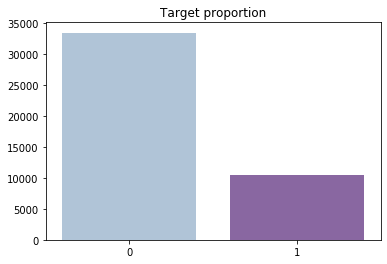

In [5]:
target = 'income_>50K'
features = data.columns.drop(target).tolist()

counts = data[target].value_counts()

print('Соотношение целевой переменной:')
print(f'0 (доход меньше 50к) - {counts[0]/data.shape[0]*100:.0f}%')
print(f'1 (доход больше 50к) - {counts[1]/data.shape[0]*100:.0f}%')
  
plt.title('Target proportion')
sns.barplot(counts.index, counts.values, palette='BuPu')
plt.show()

In [6]:
data.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income_>50K         int64
dtype: object

In [7]:
# continuous_columns = list(data.select_dtypes('int').columns)[:-1]
continuous_columns = ['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'age', 'educational-num']
continuous_columns

['fnlwgt',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'age',
 'educational-num']

In [8]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

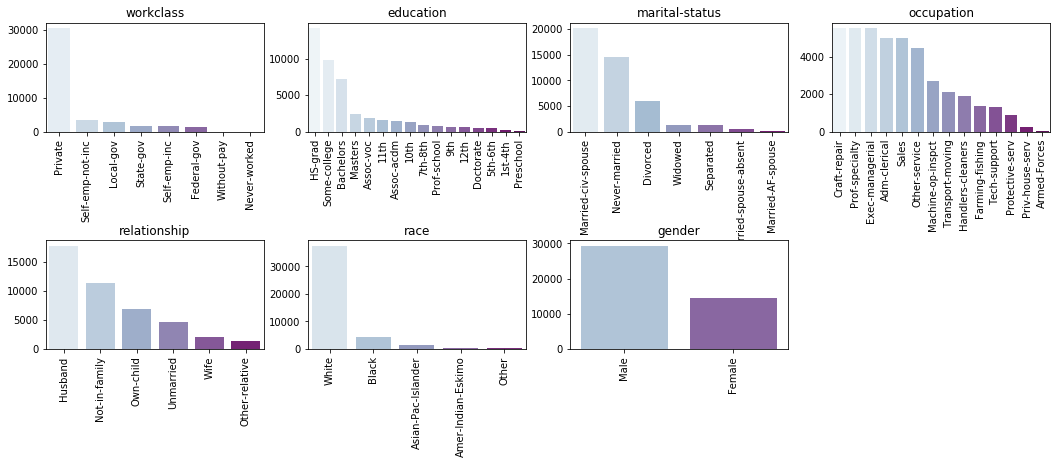

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 6))

for i, ax in enumerate(axes.flat):
    if i != 7:
        counts = data[categorical_columns[i]].value_counts()
        sns.barplot(counts.index, counts.values, ax=ax, palette='BuPu')
        ax.set_title(categorical_columns[i])
        ax.tick_params(axis='x', labelrotation=90)
    else:
        break

axes[1][3].set_visible(False)
plt.subplots_adjust(hspace = 1)
plt.show()

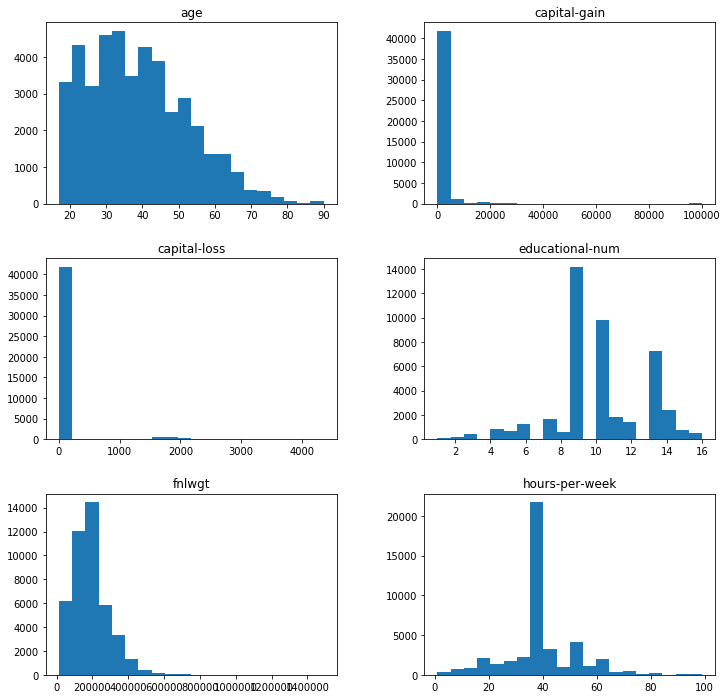

In [10]:
data[continuous_columns].hist(figsize=(12,12), bins=20, grid=False)
plt.show()

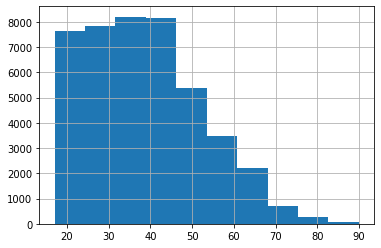

In [11]:
data['age'].hist()

Видим сильную корреляцию по многим признакам, особенно по образованию.

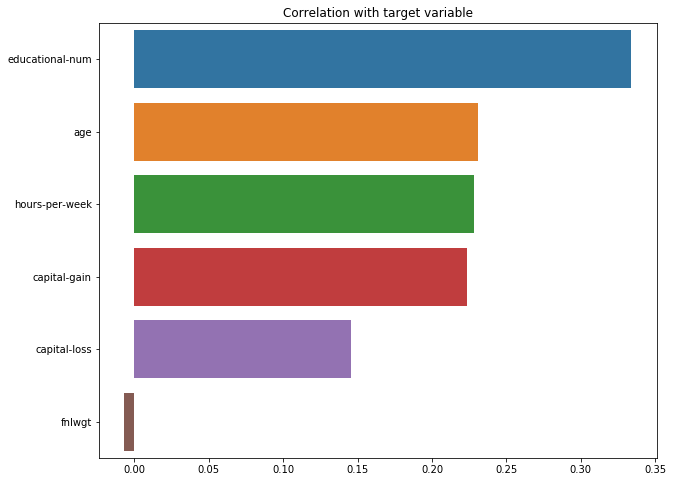

In [12]:
corr_with_target = data[features + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

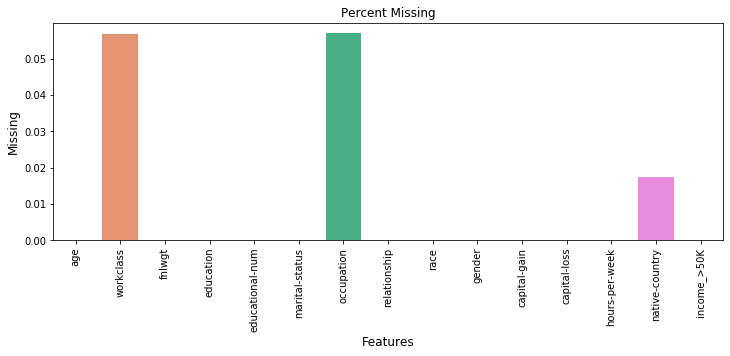

In [13]:
nan_df = (data.isna().sum() / data.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(12,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Заменяем пропуски на моды

In [14]:
data['workclass'].fillna(data['workclass'].mode()[0], inplace=True)
data['occupation'].fillna(data['occupation'].mode()[0], inplace=True)
data['native-country'].fillna(data['native-country'].mode()[0], inplace=True)

In [15]:
from sklearn.model_selection import train_test_split

x_data = data.drop(columns='income_>50K')
y_data = data['income_>50K']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)
x_train

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
31830,26,Private,335998,HS-grad,9,Never-married,Sales,Not-in-family,White,Female,0,0,38,United-States
22657,22,Private,231912,Assoc-voc,11,Never-married,Adm-clerical,Own-child,White,Female,0,0,37,United-States
11228,33,Private,159442,Bachelors,13,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,United-States
12172,29,Private,54932,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
22843,67,Private,169435,9th,5,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34140,77,Private,117898,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
13927,58,Private,214502,9th,5,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,50,United-States
919,23,Private,362623,10th,6,Married-civ-spouse,Other-service,Husband,White,Male,0,1573,30,Mexico
38467,36,Local-gov,305714,HS-grad,9,Never-married,Other-service,Unmarried,Black,Female,0,0,70,United-States


In [16]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, key=None):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()

        data['age_bins'] = np.nan

        data.loc[data['age'] <= 18 , 'age_bins'] = '<=18'
        data.loc[(data['age'] > 18) & (data['age'] < 25), 'age_bins'] = '18-25'
        data.loc[(data['age'] >= 25) & (data['age'] < 35), 'age_bins'] = '25-35'
        data.loc[(data['age'] >= 35) & (data['age'] < 45), 'age_bins'] = '35-45'
        data.loc[(data['age'] >= 45) & (data['age'] < 55), 'age_bins'] = '45-55'
        data.loc[(data['age'] >= 55) & (data['age'] < 65), 'age_bins'] = '55-65'
        data.loc[(data['age'] >= 65) & (data['age'] < 75), 'age_bins'] = '65-75'
        data.loc[(data['age'] >= 75) & (data['age'] < 85), 'age_bins'] = '75-85'
        data.loc[data['age'] >= 85 , 'age_bins'] = '>85'

        # берем среднее для признаков по возрастным бинам
        data_grp_by_hrs = data.groupby(by=['age_bins']).agg(mean_hrs=('hours-per-week', 'mean')).reset_index()
        data = data.merge(data_grp_by_hrs, on='age_bins')

        data_grp_by_fnlwgt = data.groupby(by=['age_bins']).agg(mean_fnlwgt=('fnlwgt', 'mean')).reset_index()
        data = data.merge(data_grp_by_fnlwgt, on='age_bins')

        data_grp_by_cg = data.groupby(by=['age_bins']).agg(mean_cg=('capital-gain', 'mean')).reset_index()
        data = data.merge(data_grp_by_cg, on='age_bins')
        
        data_grp_by_cg = data.groupby(by=['age_bins']).agg(mean_cl=('capital-loss', 'mean')).reset_index()
        data = data.merge(data_grp_by_cg, on='age_bins')
        
        data_grp_by_cg = data.groupby(by=['age_bins']).agg(mean_enum=('educational-num', 'mean')).reset_index()
        data = data.merge(data_grp_by_cg, on='age_bins')
        
        
        
        # делим страны на части света
        europe = ['Portugal', 'Italy', 'England', 'Germany', 'Poland', 'Greece', 'Ireland', 'Scotland', 'France',
                  'Yugoslavia', 'Hungary', 'Holand-Netherlands']

        other = ['South', 'Philippines', 'Haiti', 'Nicaragua', 'Trinadad&Tobago']

        middle_east = ['Iran', 'India']

        latin = ['Ecuador', 'Mexico', 'Dominican-Republic', 'Jamaica', 'Puerto-Rico', 'Cuba', 'El-Salvador', 
                'Guatemala', 'Columbia', 'Peru', 'Honduras']

        asia = ['Japan', 'China', 'Vietnam', 'Thailand', 'Cambodia', 'Taiwan', 'Laos', 'Hong']

        north_america = ['Canada', 'United-States', 'Outlying-US(Guam-USVI-etc)']
        
        data['world_reg'] = np.nan
        data.loc[data['native-country'].isin(europe), 'world_reg'] = 'europe'
        data.loc[data['native-country'].isin(north_america), 'world_reg'] = 'north_america'
        data.loc[data['native-country'].isin(asia), 'world_reg'] = 'asia'
        data.loc[data['native-country'].isin(latin), 'world_reg'] = 'latin'
        data.loc[data['native-country'].isin(middle_east), 'world_reg'] = 'middle_east'
        data.loc[data['native-country'].isin(other), 'world_reg'] = 'other'


        # берем среднее для признаков по региональным бинам
        data_grp_by_hrs = data.groupby(by=['native-country']).agg(mean_hrs_reg=('hours-per-week', 'mean')).reset_index()
        data = data.merge(data_grp_by_hrs, on='native-country')

        data_grp_by_fnlwgt = data.groupby(by=['native-country']).agg(mean_fnlwgt_reg=('fnlwgt', 'mean')).reset_index()
        data = data.merge(data_grp_by_fnlwgt, on='native-country')

        data_grp_by_cg = data.groupby(by=['native-country']).agg(mean_cg_reg=('capital-gain', 'mean')).reset_index()
        data = data.merge(data_grp_by_cg, on='native-country')
        
        data_grp_by_cg = data.groupby(by=['native-country']).agg(mean_cl_reg=('capital-loss', 'mean')).reset_index()
        data = data.merge(data_grp_by_cg, on='native-country')
        
        data_grp_by_cg = data.groupby(by=['native-country']).agg(mean_enum_reg=('educational-num', 'mean')).reset_index()
        data = data.merge(data_grp_by_cg, on='native-country')
        
        return data[['mean_hrs', 'mean_fnlwgt', 'mean_cg', 'mean_cl', 'mean_enum',
                     'mean_hrs_reg', 'mean_fnlwgt_reg', 'mean_cg_reg', 'mean_cl_reg', 'mean_enum_reg']]

    
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[[self.column]]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]




final_transformers = list()


# новые признаки
gen_transformer = Pipeline([
                ('generator', FeatureGenerator())
            ])
final_transformers.append(('gen', gen_transformer))


# ohe
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
                ('scaler', StandardScaler(cont_col)) # добавляем стандартизацию
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

In [17]:
set(data.columns) - set(continuous_columns) - set(categorical_columns)

{'income_>50K'}

Проверяем качество

--------------------------------------------------------------------------------------
1 GradientBoosting
Best Threshold=0.341372, F-Score=0.723, Precision=0.690, Recall=0.760
classification_report

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      6673
           1       0.69      0.76      0.72      2119

    accuracy                           0.86      8792
   macro avg       0.81      0.83      0.81      8792
weighted avg       0.87      0.86      0.86      8792



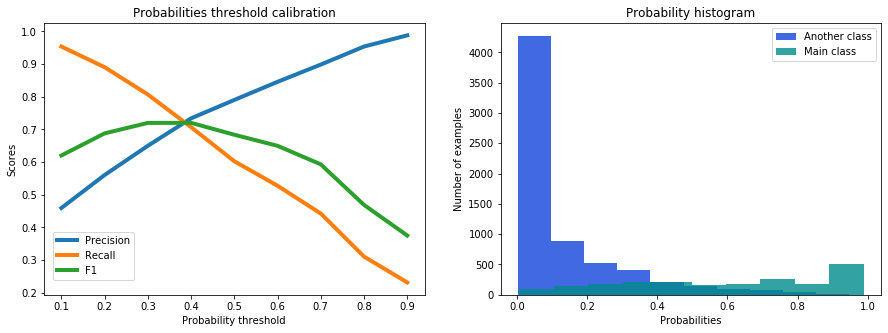

Confusion matrix, without normalization


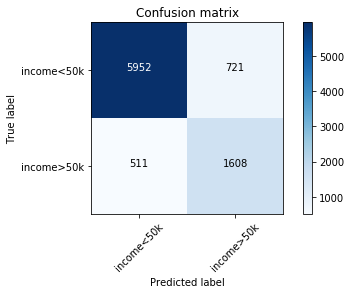

--------------------------------------------------------------------------------------
2 lgbm
Best Threshold=0.356775, F-Score=0.737, Precision=0.705, Recall=0.773
classification_report

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      6673
           1       0.70      0.77      0.74      2119

    accuracy                           0.87      8792
   macro avg       0.82      0.83      0.82      8792
weighted avg       0.87      0.87      0.87      8792



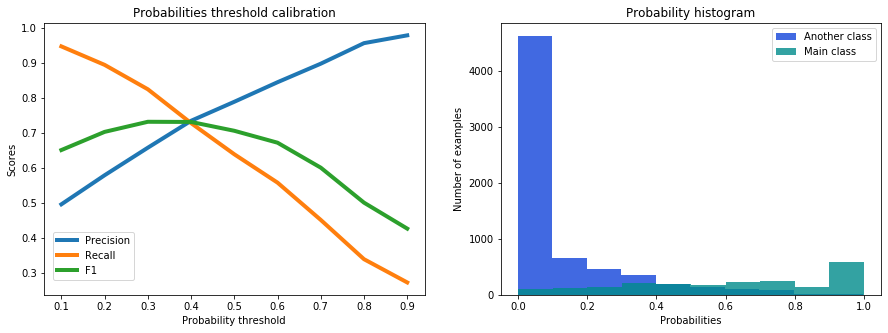

Confusion matrix, without normalization


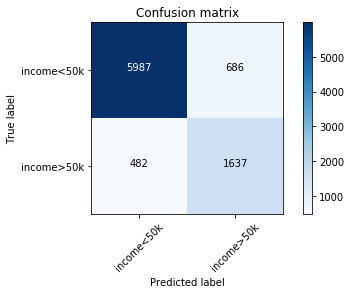

--------------------------------------------------------------------------------------
3 CatBoost
Best Threshold=0.321217, F-Score=0.743, Precision=0.681, Recall=0.816
classification_report

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6673
           1       0.68      0.82      0.74      2119

    accuracy                           0.86      8792
   macro avg       0.81      0.85      0.82      8792
weighted avg       0.88      0.86      0.87      8792



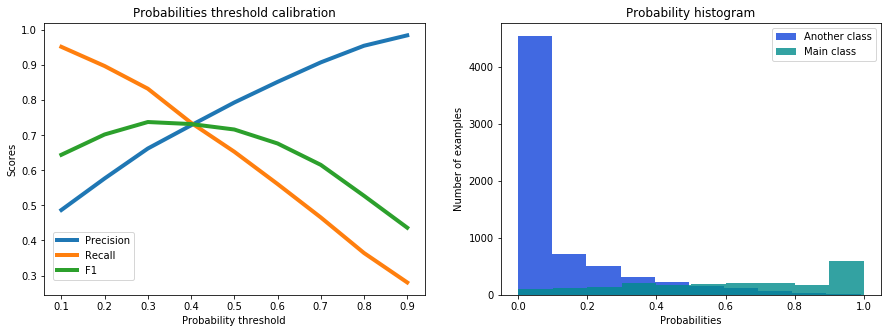

Confusion matrix, without normalization


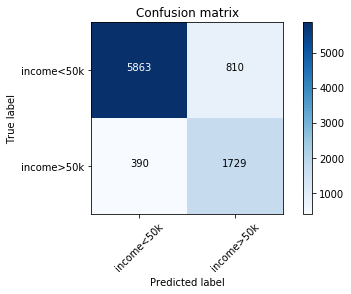

In [18]:
results = {
    'classifier': [], 
    'F-Score': [], 
    'Precision': [], 
    'Recall': []
}

model_names = ['GradientBoosting', 'lgbm', 'CatBoost']
models = [GradientBoostingClassifier(random_state=42), lgbm.LGBMClassifier(random_state=42), 
         catb.CatBoostClassifier(random_state=42, silent=True)]
 
def learning_pipline(classifier):
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', classifier),
    ])

    pipeline.fit(x_train, y_train)
    return pipeline.predict_proba(x_test)[:, 1]


### Анализ метрик

for i in range(len(models)):
    print('--------------------------------------------------------------------------------------')
    print(i+1, model_names[i])
    results['classifier'].append(model_names[i])
    preds = learning_pipline(models[i])
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

    results['F-Score'].append(fscore[ix])
    results['Precision'].append(precision[ix])
    results['Recall'].append(recall[ix])
    
    print('classification_report\n\n' + classification_report(y_test, preds>thresholds[ix]))
    show_proba_calibration_plots(preds, y_test)

    
    plot_confusion_matrix(confusion_matrix(y_test, preds>thresholds[ix]), classes=['income<50k', 'income>50k'],
                          title='Confusion matrix')
    plt.show()




### Делаем PU learning

In [19]:
p_range = np.arange(0.05, 0.95, 0.1)
p_range

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])

In [20]:
f1_max = 0
p_max = 0
y_predict_best = []
sample_test_best = []

for p in p_range:
    mod_data = data.copy()
    #get the indices of the positives samples
    pos_ind = np.where(mod_data['income_>50K'].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)
    
    
    # определяем количество позитивно размеченных
    pos_sample_len = int(np.ceil(p * len(pos_ind)))
    
    
    # делаем random negative sampling
    pos_sample = pos_ind[:pos_sample_len]
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    x_data = mod_data.iloc[:,:-2].values # just the X 
    y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
    y_positive = mod_data.iloc[:,-2].values # original class

    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    sample_train_x = sample_train.drop(columns=['income_>50K', 'class_test'])
    sample_train_y = sample_train[['income_>50K']]
    sample_test_x = sample_test.drop(columns=['income_>50K', 'class_test'])
    sample_test_y = sample_test[['income_>50K']]

    # обучение
    pipeline = Pipeline([
            ('features',feats),
            ('classifier', catb.CatBoostClassifier(random_state=42, silent=True)),
        ])

    pipeline.fit(sample_train_x, sample_train_y)
    y_predict = pipeline.predict(sample_test_x)
    
    f1 = f1_score(sample_test_y, y_predict)
    if f1 > f1_max:
        f1_max = f1
        p_max = p
        sample_test_best = sample_test_y
        y_predict_best = y_predict
    
print(f'Best f1={f1_max} at p={p_max}')

Best f1=0.6436773308297826 at p=0.05


In [21]:
results['classifier'].append('PU-learning')
results['F-Score'].append(f1_score(sample_test_best, y_predict_best))
results['Precision'].append(precision_score(sample_test_best, y_predict_best, average='binary'))
results['Recall'].append(recall_score(sample_test_best, y_predict_best, average='binary'))

In [22]:
df_results = pd.DataFrame(results).sort_values('F-Score', axis=0, ascending=False).reset_index(drop=True)
df_results

,classifier,F-Score,Precision,Recall
0,CatBoost,0.742649,0.681102,0.816423
1,lgbm,0.737340,0.704819,0.773006
2,GradientBoosting,0.723433,0.690395,0.759792
3,PU-learning,0.643677,0.500168,0.902674


Лучшие результаты показал Catboost, однако при частичной разметке на текущем датасете скор улучшить не получилось (хотя получится большой recall)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

На мой взгляд 2-step approach должен быть более эффективным, т.к. предполагает алгоритм схожий с ансаблями - когда мы улучшаем результат за счет подачи результатов одной модели на вход другой модели.